In [2]:
!pip install skorch

     |████████████████████████████████| 155 kB 2.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [172]:
!pip install mmdnn

     |████████████████████████████████| 318 kB 2.3 MB/s            


In [3]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1982.2 MB 4.1 kB/s eta 0:00:011  |█                               | 61.6 MB 8.6 MB/s eta 0:03:44     |█████▌                          | 342.8 MB 10.5 MB/s eta 0:02:36     |██████████████████████▌         | 1393.1 MB 9.6 MB/s eta 0:01:02     |█████████████████████████████▉  | 1847.7 MB 8.6 MB/s eta 0:00:16
     |████████████████████████████████| 17.6 MB 144 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 2.3 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0.dev20210415+cu101
    Uninstalling torch-1.9.0.dev20210415+cu101:
      Successfully uninstalled torch-1.9.0.dev20210415+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0.dev20210510+cu101
    Uninstalling torchvision-0.10.0.dev20210510+cu101:
      Successfully uninstalled torchvision-0.10.0.dev20210510+cu101
You should consi

In [286]:
!pip3 install --upgrade tensorflow-gpu

     |████████████████████████████████| 458.3 MB 16 kB/s              
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.5.0
    Uninstalling tensorflow-gpu-2.5.0:
      Successfully uninstalled tensorflow-gpu-2.5.0


In [275]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 458.3 MB 16 kB/s              
     |████████████████████████████████| 1.3 MB 31.4 MB/s            
     |████████████████████████████████| 5.6 MB 38.5 MB/s            
     |████████████████████████████████| 462 kB 38.8 MB/s            
     |████████████████████████████████| 4.4 MB 40.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30693 sha256=f1854b277822580858432aebb70fc38e7977469ffdb500e60342f16871f35570
  Stored in directory: /root/.cache/pip/wheels/22/4c/94/0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalle

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn import metrics

from tqdm import tqdm

In [5]:
!nvidia-smi

Sun Jun 12 04:18:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [142]:
segmentation_classifier = keras.models.load_model('../models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')
segmentation_classifier.summary()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_3[0][0]       

In [273]:
# log dice loss is custom, so can't load. but since I only want inference, will ignore the loss func. (might have to retrain?)

optic_disk = load_model('../models/optic_disk/aug_segmenter_adam3_best_weights.h5', compile=False) # failed :(
optic_disk.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 480, 480) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 480, 480) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (BatchNormalization)    (None, 32, 480, 480) 128         conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_3 (Dropout)               (None, 32, 480, 480) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

In [293]:
qual_assurance = load_model('../models/quality_assurance/IQA_model.h5')

In [294]:
qual_assurance.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [2]:
# code in one place, running in another directory
# code is to be run in below directory

os.chdir("/users/riya/race/classifier_experiments/CNN_train")

In [3]:
!ls

dataset  outputs


## Prepare Dataset

### Prepare Optic Disk Dataset

Code in Markdown form (don't run again!)

```python
# will generate a csv of all the centers of the optic disks per id, this will speed up classification 
    
csv_path = "/users/riya/race/csv/image_race_data.csv" 
data_path = "/users/riya/race/dataset/fundus/" # takes in fundus images
save_path = "/users/riya/race/optic_disk/DeepROP/dataset/" 

# 1. Copy DeepROP folder into 
# 2. get all the fundus images into DeepROP folder in the dataset location, just copy from data_path 
# 3. run the DeepROP folder using docker. Use docker mount. Get the output
# 4. Save the .csv. 
# 5. Extract image id from full path column and create new image id column. Save the .csv and now you can use that.
    
# 1 Done
# 2

# getting all the files in the source directory

files = os.listdir(data_path)
for i in files:
    img_id = os.path.splitext(i)[0]
    img = Image.open(data_path + img_id + ".png")
    img.save(save_path + img_id + ".bmp") 

```

### Prepare Race Dataset

We'll try a 70/10/20 split (train/val/test). We don't have access to info outside of black/white and posterior, so we'll just do a simple split.

In [ ]:
race_data = pd.read_csv("/users/riya/race/csv/image_race_data.csv")

In [ ]:
pd.value_counts(race_data['race'])

In [151]:
def prepare_dataset():
    
    csv_path = "/users/riya/race/csv/image_race_data.csv"
    data_path = "/users/riya/race/dataset/segmentations/"
    save_path = "/users/riya/race/classifier_experiments/CNN_train/dataset/"
    QA_csv_path = "../optic_disk/DeepROP/quality_assurance/QA.csv"
    
    race_data = pd.read_csv(csv_path)
    
    # only choose race_data ids that have (x,y) coordinates
    
    QA_csv = pd.read_csv(QAcsv_path)
    QA_csv.columns.values[0] = "img_id"
    QA_csv.columns = QA_csv.columns.to_series().apply(lambda x: x.strip())
    QA_csv[['img_id', 'Full path', 'x', 'y', 'is_posterior']]
    
    is_posterior_True = QA_csv[QA_csv['is_posterior'] == True]
    working_ids = np.array(is_posterior_True['img_id'])
    
    race_optic_data = pd.DataFrame(columns = ['subject_id', 'race', 'variable', 'value', 
                                          'image_id', 'fundus_location', 'segmentation_location'])

    for i in range(len(race_data)):
        row = race_data.loc[(i)]
        if row['image_id'] in working_ids:
            race_optic_data = race_optic_data.append(row)
    
    race_data = race_optic_data # reassign original
    
    race_data['stratify'] = race_data['race'] + '_' + race_data['variable'] 
    # new column so I can account for both variable and race in my stratification
    
    ratio_train = 0.7
    ratio_val = 0.1
    ratio_test = 0.2
    
    # split into 80% train and val, 20% test
    
    X_intermediate, X_test, y_intermediate, y_test = train_test_split(race_data, race_data['race'], test_size=ratio_test, 
                                                        stratify = race_data['stratify'], random_state=86)
    
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining
    
    # split into 70% train and 10% val
    
    X_train, X_val, y_train, y_val = train_test_split(X_intermediate, X_intermediate['race'], test_size=ratio_val_adjusted, 
                                                        stratify = X_intermediate['stratify'], random_state=86)

    
    def populate_folders(data_df, data_type):
    
        for i in tqdm(range(len(data_df))):
            data_df.reset_index(drop=True, inplace=True)
            img_id = data_df['image_id'][i]
            race = data_df['race'][i]

            img = np.array(Image.open(data_path + str(img_id) + '.bmp'))
            img = Image.fromarray(img)

            img.save(save_path + str(data_type) + '/' + str(race) + '/' + str(img_id) + '.bmp')
    
    populate_folders(X_train, 'train')
    populate_folders(X_val, 'val')
    populate_folders(X_test, 'test')


In [152]:
prepare_dataset() # proper train test split getting completed

100%|██████████| 675/675 [00:04<00:00, 156.43it/s]


### Model Definitions

In [56]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model

    def forward(self, x):
        return self.model(x)

In [135]:
# fail :( class OpticDiskSegmenter(nn.Module):


## Preprocessing

Options for different tests:
1. Skeleton = True,
    Shadow = True then
    Region has two options 
    Radius has two options
2. Original Training: shadow = False & Skeleton = False
3. skeletonization training: shadow = False & skeleton = True & ring = False
4. no skeletonization training: Skeleton = false & Shadow = true
5. training with a ring: shadow is true, skeleton is true/False, ring is True

In [141]:
'hello.bmp' + '.bmp'

'hello.bmp.bmp'

### General Functions

In [130]:
len(checksum_arr)

3371

In [5]:
def checksum(optic_csv_path):
    
    # Turns out that around 31 of the images are actual duplicates! I looked at 10 and saw that they were 
    # (or VERY close to duplicates), with difference image having very few nonzero pixels
    # Checksum is getting the best of it, then.
    
    checksum_arr = []
    id_arr = []

    # optic_csv_path = "../../optic_disk/DeepROP/quality_assurance/QA.csv"
    data_compare_path = "/users/riya/race/dataset/segmentations/"

    QA_csv = pd.read_csv(optic_csv_path)

    QA_csv.columns.values[0] = "img_id"
    QA_csv.columns = QA_csv.columns.to_series().apply(lambda x: x.strip())
    QA_csv[['img_id', 'Full path', 'x', 'y', 'is_posterior']]

    QA_csv = QA_csv[QA_csv['is_posterior'] == True]

    for i in tqdm(QA_csv['img_id']):
        img_compare = np.array(Image.open(data_compare_path + str(i) + '.bmp'))
        all_sum = np.concatenate(img_compare).sum()
        col_sum = img_compare[:,100:240].sum()
        
        checksum_arr.append(all_sum + col_sum)
        id_arr.append(i)
    
    checksum_dict = {id_arr[i]: checksum_arr[i] for i in range(len(id_arr))}
    
    return QA_csv, checksum_dict

### Functions to be Lamda Applied

In [4]:
def determine_image_center(img, img_size, QA_csv, checksum_dict): # using optic disk
    
    id_og = '' # original id of image, for comparison
    
    img_og = np.array(img) # our original image
    img_og = img_og[:,:,0]
    
    checksum_og = np.concatenate(img_og).sum() + img_og[:,100:240].sum()
    
    id_og = list(checksum_dict.keys())[list(checksum_dict.values()).index(checksum_og)] # finding id for which checksum_og matches
    
    # all images are of size 480 x 480
    
    img_row = QA_csv[QA_csv['img_id'] == id_og] # check if string
    
    y_og = img_row['y'].reset_index(drop=True)[0]
    x_og = img_row['x'].reset_index(drop=True)[0]
    
    x_pos = (80 + y_og) * img_size[1]/640 # x size is 640, cropped that way
    y_pos = (x_og)* img_size[0]/480 # y size is 480 (also, height is first in img size tuple, so the 0)
    
    # never subtract 480 because from the top :( and image orientation is naturally from the top)
    
    disk_center = (int(x_pos), int(y_pos)) # for (224, 224) image that will be created soon
    
    return disk_center

In [6]:
def multiple_ring_mask(disk_center, num_rings, ring_radiuses,
                       image_size = (224, 224)):
    
    # ex. ring_radiuses: [[0, 15], [75, 90]]
    
    center_mask = np.full(image_size, 0, dtype=np.uint8) 

    for i in range(num_rings):
        ring_mask = np.full(image_size, 0, dtype=np.uint8)  
        # for each of the radiuses given dark around the outer circle
        cv2.circle(ring_mask, disk_center, ring_radiuses[i][1], (255, 255, 255), -1) 
        cv2.circle(ring_mask, disk_center, ring_radiuses[i][0], (0,0, 0), -1) # the white for that region
    
        center_mask = center_mask + ring_mask 

    # idk why exactly this is needed...? 
    # probably related to the fact that adding the original center_mask does NOT make sense, but appears to work
    center_mask = cv2.bitwise_not(center_mask) 
    
    # back_mask = cv2.bitwise_not(center_mask)
    # return cv2.bitwise_or(img, img, mask=back_mask)
    
    return center_mask

In [ ]:
# modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=center_mask)

### Good code next steps: functionalize all of this code MORE!!

#### Goal of Half-Skeletonize:

Goal: trying to prove the theory that skeletonizing only the exterior regions will get a higher AUC, possibly by using thinner pixels in exterior regions and thicker pixels in interior regions

In [30]:
def half_skeletonize(img, disk_center, skeleton_radiuses, region,
                    image_size = (224, 224)): 
    # skeletonize inside these radiuses.
    # let region be skeletonized center or skeletonized outside
    
    # Ideas: 0 - 60 no skeletonize, 60 - 120 skeletonize
    # 0 - 45 no skeletonize, 45 and on skeletonize
    
    img = np.array(img)
    img = cv2.resize(img, image_size)
    
    # defining channel which will be duplicated late (in case it's not already with Image Folder??)
    channel = img[:,:,0]
    
    # created duplicate image to skeletonize
    skeleton_channel = np.copy(channel)
    skeleton_channel[skeleton_channel > 0] = 255       
    skeleton_channel = skeletonize(skeleton_channel, method='lee')
    
    # create masks to shadow channel & skeleton_channel
    center_mask = np.full(image_size, 255, dtype=np.uint8)
    # large black circle on outside
    cv2.circle(center_mask, disk_center, skeleton_radiuses[1], (0, 0, 0), -1)
    # smaller white circle on inside
    cv2.circle(center_mask, disk_center, skeleton_radiuses[0], (255, 255, 255), -1)
    
    back_mask = cv2.bitwise_not(center_mask)
    
    if (region == 'skeleton_center'): # could be for ring or not for ring
        channel = cv2.bitwise_or(channel, channel, mask=center_mask)
        skeleton_channel = cv2.bitwise_or(skeleton_channel, skeleton_channel, mask=back_mask)

    if (region == 'skeleton_background'):
        # masking the center region
        channel = cv2.bitwise_or(channel, channel, mask=back_mask)
        skeleton_channel = cv2.bitwise_or(skeleton_channel, skeleton_channel, mask=center_mask)
    
    final_channel = channel + skeleton_channel
    
    img[:,:,0] = final_channel
    img[:,:,1] = final_channel
    img[:,:,2] = final_channel
    
    img = Image.fromarray(img)

    return img

In [31]:
my_test_img = np.array(Image.open("/users/riya/race/dataset/segmentations/27313.bmp"))
test_channels = np.repeat(my_test_img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))

In [38]:
return_img = half_skeletonize(test_channels, (58, 129), (0, 60), 'skeleton_background')

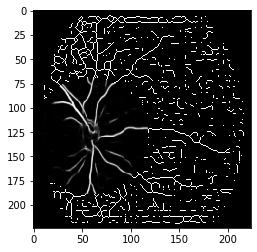

In [39]:
plt.imshow(return_img, interpolation='nearest')

In [157]:
# Already done this, before I saved my images
# Yay, we did the same thing, repeating the image thrice to create the three layers. I can just do that part.

# Oh, I see. Rather than saving ALL the images (as I wrongly did), it's so much easier to just make them in the train code!

# depending on the inputs, I can run this code 8 times to train this model. It'll be easy to train at that point!

def shadow_regions(img, skeleton, disk_center, shadow, radius, 
                   shadow_ring, num_rings, ring_radiuses, region, 
                   image_size = (224, 224)):
    
    img = np.array(img)
    img = cv2.resize(img, image_size)
    
    # defining channel which will be duplicated late (in case it's not already with Image Folder??)
    channel = img[:,:,0]
    
    if skeleton is True:
        # can binarize all 3 channels, but will go 1 at a time
        channel[channel > 0] = 255       
        modified_img = skeletonize(channel, method='lee')
        
    elif skeleton is not True:
        modified_img = channel
    
    if shadow is True: # want to do either shadow or shadow_ring, not both
        
        if shadow_ring is True:
            # ring_radiuses is [inner_radius, outer_radius]
            
            # for cases of multiple rings, we're just going to pop over to another function lol. 
            # ring_radiuses will be array of arrays.
            if num_rings > 1: 
                center_mask = multiple_ring_mask(disk_center, num_rings, ring_radiuses,
                                                image_size = (224, 224))
        
            elif num_rings <= 1: # 1 ring only or no ring, only 1 ring really applies here
                # developing mask that darkens ring portion
                center_mask = np.full(image_size, 255, dtype=np.uint8) 
                # radius i changes, center, color, fill is the same
                cv2.circle(center_mask, disk_center, ring_radiuses[1], (0, 0, 0), -1)
                # adding circle to darken inside region
                cv2.circle(center_mask, disk_center, ring_radiuses[0], (255,255, 255), -1)
        
        elif shadow_ring is not True:
            # developing mask that darkens center portion
            center_mask = np.full(image_size, 255, dtype=np.uint8)
            # radius i changes, center, color, fill is the same
            cv2.circle(center_mask, disk_center, radius, (0, 0, 0), -1) # disk_center received from optic disk segmenter, tuple

        # developing mask that darkens background region (same in case of ring)
        back_mask = cv2.bitwise_not(center_mask)

        if (region == 'dark_center'): # could be for ring or not for ring
            modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=center_mask)
            
        if (region == 'dark_background'):
            modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=back_mask)
            
    elif shadow is not True: # if condition here for clarity     
        modified_img2 = modified_img
        
    img[:,:,0] = modified_img2
    img[:,:,1] = modified_img2
    img[:,:,2] = modified_img2
    
    img = Image.fromarray(img)

    return img

### Testing The Transforms

#### Shadow Center & Optic Disk Manual

In [11]:
my_test_img = np.array(Image.open("/users/riya/race/dataset/segmentations/27313.bmp"))
# my_test_img = cv2.resize(my_test_img, (224, 224)) at that point, images are NOT resized yet
test_channels = np.repeat(my_test_img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))

In [12]:
QA_csv, checksum_dict = checksum("../../optic_disk/DeepROP/quality_assurance/QA.csv")

100%|██████████| 3371/3371 [00:12<00:00, 260.02it/s]


In [13]:
disk_center = determine_image_center(test_channels, (224, 224), QA_csv, checksum_dict)

In [14]:
disk_center

(58, 94)

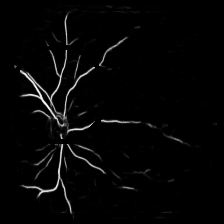

In [39]:
shadow_regions(test_channels, False, disk_center, True, 80, 
                   True, [45,50], 'dark_center', 
                   image_size = (224, 224))

In [ ]:
shadow_regions(test_channels, True, disk_center, False, 80, 
                   False, [45,90], 'dark_center', 
                   image_size = (224, 224))

In [ ]:
shadow_regions(test_channels, True, disk_center, False, 80, 
                   False, [45,90], 'dark_center', 
                   image_size = (224, 224))

In [ ]:
# original model
    train(data_dir, 0, [0,0], 'none')
    
    # skeletonized control
    train(data_dir, 0, [0,0], 'none', skeleton =True, shadow = False, shadow_ring = False)
    
    # training 6 skeleton & shadow (no ring) models for experiment #2
    
    train(data_dir, 45, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    
    # ---------------------
    
    train(data_dir, 45, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    train(data_dir, 60, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    train(data_dir, 60, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    train(data_dir, 90, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    
    # --------------------- training
    
    train(data_dir, 90, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    # training 2 skeleton & shadow (with ring) models for experiment #2
    
    train(data_dir, 0, [45, 90], 'dark_center',skeleton=True, shadow = True, shadow_ring = True)
    train(data_dir, 0, [45, 90], 'dark_background',skeleton=True, shadow = True, shadow_ring = True)

#### Lambda Transforms Style :D

### Train Code

In [59]:
def train(data_dir, radius, ring_radiuses, region, skeleton=False, shadow = False, shadow_ring = False,
          num_classes=2, batch_size=64, num_epochs=50, lr=0.001, image_size = (224, 224)): 
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # 
    if device == 'cuda:1': # using all available gpus
        torch.cuda.empty_cache()
    if skeleton is True: # Experiment #2: skeleton true, shadow true
        shadow = True
        f_params = f'./outputs/checkpoints/model_shadow_regions_{region}_{radius}_skeletonized_epoch{num_epochs}.pt'
        f_history = f'./outputs/histories/model_shadow_regions_{region}_{radius}_skeletonized_epoch{num_epochs}.json'
        csv_name = f'./outputs/probabilities/shadow_regions_{region}_{radius}_skeletonized_epoch{num_epochs}.csv'
    elif shadow is True: # Experiment #3: skeleton false, shadow true
        f_params = f'./outputs/checkpoints/model_shadow_regions_{region}_{radius}_epoch{num_epochs}.pt'
        f_history = f'./outputs/histories/model_shadow_regions_{region}_{radius}_epoch{num_epochs}.json'
        csv_name = f'./outputs/probabilities/shadow_regions_{region}_{radius}_epoch{num_epochs}.csv'
    else: # Original training: skeleton false, shadow false
        f_params = f'./outputs/checkpoints/model_original_epoch{num_epochs}.pt'
        f_history = f'./outputs/histories/model_original_epoch{num_epochs}.json'
        csv_name = f'./outputs/probabilities/original_epoch{num_epochs}.csv'
        
    # fix these transforms w/ new optic disk. Done.
    
    optic_disk_csv = "../../optic_disk/DeepROP/quality_assurance/QA.csv"
    QA_csv, checksum_dict = checksum(optic_disk_csv)
    
    train_transforms = transforms.Compose([transforms.Lambda
                                      (lambda img: shadow_regions(img, skeleton, determine_image_center(img, image_size, QA_csv, checksum_dict), 
                                                                  shadow, radius, shadow_ring, ring_radiuses, region)), # image size pre-defined
                                           # transforms.Resize(image_size),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(25),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.5, 0.5, 0.5],
                                                                [0.5, 0.5, 0.5])]) # why this normalizing?
    
    test_transforms = transforms.Compose([transforms.Lambda
                                      (lambda img: shadow_regions(img, skeleton, determine_image_center(img, image_size, QA_csv, checksum_dict), 
                                                                  shadow, radius, shadow_ring, ring_radiuses, region)),
                                          # transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],
                                                               [0.5, 0.5, 0.5])])

    train_folder = os.path.join(data_dir, 'train') # only training on segmentations      
    val_folder = os.path.join(data_dir, 'val')
    test_folder = os.path.join(data_dir, 'test')
    
    print ("Train/Test/Val datasets to be created. Thank you for your patience.")

    # I guess this automatically creates 3 channels
    train_dataset = datasets.ImageFolder(train_folder, train_transforms)
    val_dataset = datasets.ImageFolder(val_folder, test_transforms)
    test_dataset = datasets.ImageFolder(test_folder, test_transforms)
    
    print ("Train/Test/Val datasets created.")

    labels = np.array(train_dataset.samples)[:,1]
    
    # what even does the below code do?    
    labels = labels.astype(int) # idk what changed 6/17/22?? going from 0 and 1, to 1 and 2 labels. Ok, fixed. ipynb checkpoints!!
    black_weight = 1 / len(labels[labels == 0]) 
    white_weight = 1 / len(labels[labels == 1])
    sample_weights = np.array([black_weight, white_weight])
    weights = sample_weights[labels]
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(train_dataset), replacement=True)

    print()
    print(f'Data Directory: {data_dir}')
    print(f'Skeletonize: {skeleton}')
    print(f'Shadow: {shadow}')
    print(f'Number of Classes: {num_classes}')
    print(f'Number of black eyes: {len(labels[labels == 0])}')
    print(f'Number of white eyes: {len(labels[labels == 1])}')
    print(f'Batch Size: {batch_size}')
    print(f'Number of Epochs: {num_epochs}')
    print(f'Initial Learning Rate: {lr}')
    print(f'Device: {device}')
    print()

    # maybe increase size of validation set??
    
    checkpoint = Checkpoint(monitor='valid_loss_best',
                            f_params=f_params,
                            f_history=f_history,
                            f_optimizer=None,
                            f_criterion=None)

    # accuracy on train/validation?
    
    train_acc = EpochScoring(scoring='accuracy',
                             on_train=True,
                             name='train_acc',
                             lower_is_better=False)

    early_stopping = EarlyStopping()

    callbacks = [checkpoint, train_acc, early_stopping]

    net = NeuralNetClassifier(PretrainedModel,
                              criterion=nn.CrossEntropyLoss,
                              lr=lr,
                              batch_size=batch_size,
                              max_epochs=num_epochs,
                              module__output_features=num_classes,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.9,
                              iterator_train__num_workers=16,
                              iterator_train__sampler=sampler,
                              iterator_valid__shuffle=False,
                              iterator_valid__num_workers=16,
                              train_split=predefined_split(val_dataset),
                              callbacks=callbacks,
                              device=device)

    print ("Model Fitting")
    net.fit(train_dataset, y=None)

    img_locs = [loc for loc, _ in test_dataset.samples]
    test_probs = net.predict_proba(test_dataset)
    test_probs = [prob[0] for prob in test_probs] # probability of being black
    data = {'img_loc' : img_locs, 'probability' : test_probs}
    pd.DataFrame(data=data).to_csv(csv_name, index=False)

In [83]:
if __name__ == '__main__':
    if not os.path.isdir(os.path.join('outputs', 'probabilities')):
        os.makedirs(os.path.join('outputs', 'probabilities'))
    if not os.path.isdir(os.path.join('outputs', 'checkpoints')):
        os.makedirs(os.path.join('outputs', 'checkpoints'))
    if not os.path.isdir(os.path.join('outputs', 'histories')):
        os.makedirs(os.path.join('outputs', 'histories'))

    data_dir = os.path.join('dataset')

    # original model
    train(data_dir, 0, [0,0], 'none')
    
    # skeletonized control
    train(data_dir, 0, [0,0], 'none', skeleton =True, shadow = False, shadow_ring = False)
    
    # training 6 skeleton & shadow (no ring) models for experiment #2
    
    train(data_dir, 45, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    
    # ---------------------
    
    train(data_dir, 45, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    train(data_dir, 60, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    train(data_dir, 60, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    train(data_dir, 90, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    
    # --------------------- training
    
    train(data_dir, 90, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    # training 2 skeleton & shadow (with ring) models for experiment #2
    
    train(data_dir, 0, [45, 90], 'dark_center',skeleton=True, shadow = True, shadow_ring = True)
    train(data_dir, 0, [45, 90], 'dark_background',skeleton=True, shadow = True, shadow_ring = True)
    
    # ---------------------
    
    # training 6 no skeleton & no shadow (no ring models for experiment #3) -- 4 already succesfully done??
    
    train(data_dir, 45, [0,0], 'dark_center',skeleton=False, shadow = True, shadow_ring = False)
    train(data_dir, 45, [0,0], 'dark_background',skeleton=False, shadow = True, shadow_ring = False)

    train(data_dir, 60, [0,0], 'dark_center',skeleton=False, shadow = True, shadow_ring = False)
    train(data_dir, 60, [0,0], 'dark_background',skeleton=False, shadow = True, shadow_ring = False)
    
    # ------------------------
    
    train(data_dir, 90, [0,0], 'dark_center',skeleton=False, shadow = True, shadow_ring = False)
    train(data_dir, 90, [0,0], 'dark_background',skeleton=False, shadow = True, shadow_ring = False)

    
    # the shadow rings now
    
    train(data_dir, 0, [45, 90], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [45, 90], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    # -------------------------
    
    # time for the new shadow rings, Experiment 4
    
    train(data_dir, 0, [0, 30], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [0, 30], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    train(data_dir, 0, [30, 60], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [30, 60], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    train(data_dir, 0, [60, 90], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [60, 90], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
        # --------------
    
    train(data_dir, 0, [0, 15], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [0, 15], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    train(data_dir, 0, [15, 30], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [15, 30], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    train(data_dir, 0, [30, 45], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [30, 45], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
            # --------------
    
    train(data_dir, 0, [45, 60], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [45, 60], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    train(data_dir, 0, [60, 75], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [60, 75], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    train(data_dir, 0, [75, 90], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, [75, 90], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)
    
    # also I had the skeleton = True image sets for the above.
    
    # ----------------- time for Experiment 5. I have done most of this already. 
    # 0 - 15, 0 - 30, 0 - 45, 0 - 60, 0 - 90 are done. I just need to do 0 - 75, 0 - 105, 0 - 120 
    # 120 is for: (maximum width is 112, but for outer regions)
    
    train(data_dir, 75, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False)
    train(data_dir, 75, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)

    train(data_dir, 105, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False) 
    train(data_dir, 105, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)
    
    train(data_dir, 120, [0,0], 'dark_center',skeleton=True, shadow = True, shadow_ring = False) 
    train(data_dir, 120, [0,0], 'dark_background',skeleton=True, shadow = True, shadow_ring = False)

    # and now double for skeleton = False.  
    
    train(data_dir, 75, [0,0], 'dark_center',skeleton=False, shadow = True, shadow_ring = False)
    train(data_dir, 75, [0,0], 'dark_background',skeleton=False, shadow = True, shadow_ring = False)

    train(data_dir, 105, [0,0], 'dark_center',skeleton=False, shadow = True, shadow_ring = False) 
    train(data_dir, 105, [0,0], 'dark_background',skeleton=False, shadow = True, shadow_ring = False)
    
    train(data_dir, 120, [0,0], 'dark_center',skeleton=False, shadow = True, shadow_ring = False) 
    train(data_dir, 120, [0,0], 'dark_background',skeleton=False, shadow = True, shadow_ring = False)
    
    # experiment 6, working with 3 double rings. Already done the 0 - 45 and 90 - 45 double ring (just a 0 - 90 ring)
    
    train(data_dir, 0, 2, [[0,15],[75,90]], 'dark_center',skeleton=True, shadow = True, shadow_ring = True)
    train(data_dir, 0, 2, [[0,15],[75,90]], 'dark_background',skeleton=True, shadow = True, shadow_ring = True)

    train(data_dir, 0, 2, [[0,30],[60,90]], 'dark_center',skeleton=True, shadow = True, shadow_ring = True) 
    train(data_dir, 0, 2, [[0,30],[60,90]], 'dark_background',skeleton=True, shadow = True, shadow_ring = True) 
    
    
    train(data_dir, 0, 2, [[0,15],[75,90]], 'dark_center',skeleton=False, shadow = True, shadow_ring = True)
    train(data_dir, 0, 2, [[0,15],[75,90]], 'dark_background',skeleton=False, shadow = True, shadow_ring = True)

    train(data_dir, 0, 2, [[0,30],[60,90]], 'dark_center',skeleton=False, shadow = True, shadow_ring = True) 
    train(data_dir, 0, 2, [[0,30],[60,90]], 'dark_background',skeleton=False, shadow = True, shadow_ring = True) 
    
    # experiment 7, modified train function. only available in train1.py
    
    train(data_dir, [0, 60], 'skeleton_background', '#7(half_skeletonize)')
    train(data_dir, [0, 60], 'skeleton_center', '#7(half_skeletonize)')
    
    train(data_dir, [0, 30], 'skeleton_background', '#7(half_skeletonize)')
    train(data_dir, [0, 30], 'skeleton_center', '#7(half_skeletonize)')
    
    train(data_dir, [0, 15], 'skeleton_background', '#7(half_skeletonize)')
    train(data_dir, [0, 15], 'skeleton_center', '#7(half_skeletonize)')

NameError: name 'train' is not defined

In [40]:
!nvidia-smi

Thu Jun 23 20:57:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   57C    P0    60W / 149W |  10906MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   